Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garrettebaker. Use `wandb login --relogin` to force relogin


[LOADING HYPERPARAMETERS...]
algo : ppo
n_envs : 64
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 2048
gamma : 0.999
lmbda : 0.95
learning_rate : 0.0005
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False
INITIALIZAING ENVIRONMENTS...
building procgen...done
INITIALIZAING LOGGER...


Chain 2: 100%|██████████| 200/200 [00:02<00:00, 79.78it/s]


Lambda hat estimates:
llc-chain/0: -0.42723625898361206
llc-chain/1: -0.3653571307659149
llc-chain/2: -1.4391769170761108
llc/mean: -0.7439234256744385
llc/std: 0.6029016375541687



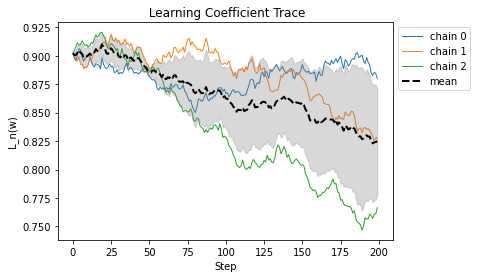

<Figure size 864x648 with 0 Axes>

  0%|          | 0/8056 [00:11<?, ?it/s]


In [1]:
import wandb
from tqdm import tqdm
import torch
import os
import shutil
import matplotlib.pyplot as plt
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy, CategoricalValueNetwork
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
from agents.ppo import PPO as AGENT
import random
import yaml
from devinterp.utils import plot_trace

# def estimate_learning_coeff(
#     model: torch.nn.Module,
#     loader: DataLoader,
#     criterion: Callable,
#     sampling_method: Type[torch.optim.Optimizer] = SGLD,
#     optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
#     num_draws: int = 100,
#     num_chains: int = 10,
#     num_burnin_steps: int = 0,
#     num_steps_bw_draws: int = 1,
#     cores: int = 1,
#     seed: Optional[Union[int, List[int]]] = None,
#     device: torch.device = torch.device("cpu"),
#     verbose: bool = True,
#     callbacks: List[Callable] = [],
# ) -> float:

# og run made with:
# python train.py --exp_name hard-run --env_name maze_aisc --param_name easy --num_levels 0 --distribution_mode easy --num_timesteps 200000000 --num_checkpoints 1000

# Excess defaults from train.py for reference:
#     parser.add_argument('--exp_name',         type=str, default = 'test', help='experiment name')
#     parser.add_argument('--env_name',         type=str, default = 'starpilot', help='environment ID')
#     parser.add_argument('--start_level',      type=int, default = int(0), help='start-level for environment')
#     parser.add_argument('--num_levels',       type=int, default = int(0), help='number of training levels for environment')
#     parser.add_argument('--distribution_mode',type=str, default = 'easy', help='distribution mode for environment')
#     parser.add_argument('--param_name',       type=str, default = 'easy-200', help='hyper-parameter ID')
#     parser.add_argument('--device',           type=str, default = 'gpu', required = False, help='whether to use gpu')
#     parser.add_argument('--gpu_device',       type=int, default = int(0), required = False, help = 'visible device in CUDA')
#     parser.add_argument('--num_timesteps',    type=int, default = int(25000000), help = 'number of training timesteps')
#     parser.add_argument('--seed',             type=int, default = random.randint(0,9999), help='Random generator seed')
#     parser.add_argument('--log_level',        type=int, default = int(40), help='[10,20,30,40]')
#     parser.add_argument('--num_checkpoints',  type=int, default = int(1), help='number of checkpoints to store')


wandb.init(project="procgen-lambdahat-estimation")
def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

torch.manual_seed(1)

####################
## HYPERPARAMETERS #
#################### 
param_name = 'easy'
gpu_device = int(0)
env_name = "maze_aisc"
start_level = 0
num_levels = 0
distribution_mode = "easy"
exp_name = "hard-run"
seed = random.randint(0,9999)
num_checkpoints = 0

print('[LOADING HYPERPARAMETERS...]')
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)

############
## DEVICE ##
############
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
device = torch.device('cuda')

#################
## ENVIRONMENT ##
#################
print('INITIALIZAING ENVIRONMENTS...')
n_steps = hyperparameters.get('n_steps', 256)
n_envs = hyperparameters.get('n_envs', 64)
# By default, pytorch utilizes multi-threaded cpu
# Procgen is able to handle thousand of steps on a single core
torch.set_num_threads(1)
env = ProcgenEnv(num_envs=n_envs,
                    env_name=env_name,
                    start_level=start_level,
                    num_levels=num_levels,
                    distribution_mode=distribution_mode, 
                    rand_region = 5) 
normalize_rew = hyperparameters.get('normalize_rew', True)
env = VecExtractDictObs(env, "rgb")
if normalize_rew:
    env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

############
## LOGGER ##
############
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + exp_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)

# List all artifacts for this run
artifacts = run.logged_artifacts()
for artifact in tqdm(artifacts):
    artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
    artifact_dir = artifact_to_download.download()
    model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"


    hidden_state_dim = 0
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)

    loaded_checkpoint = torch.load(model_file)
    model = ImpalaModel(in_channels = observation_shape[0])
    policy = CategoricalPolicy(model, False, env.action_space.n)
    if "state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        policy.load_state_dict(loaded_checkpoint['model_state_dict'])
    policy.to(device)
    agent = AGENT(env, policy, logger, storage, device, num_checkpoints, **hyperparameters)

    datapoints = 100
    dataloader = agent.generate_data_loader(datapoints)
    value_network = CategoricalValueNetwork(model, False, env.action_space.n)
    if "state_dict" in loaded_checkpoint:
        value_network.load_state_dict(loaded_checkpoint['state_dict'])
    elif "model_state_dict" in loaded_checkpoint:
        value_network.load_state_dict(loaded_checkpoint['model_state_dict'])

    learning_coeff_with_stats = estimate_learning_coeff_with_summary(
        value_network, 
        loader = dataloader, 
        criterion = torch.nn.MSELoss(),
        sampling_method=SGLD, 
        optimizer_kwargs=dict(lr=3e-8, elasticity=1., num_samples=datapoints),
        num_chains=3, 
        num_draws=200, 
        num_burnin_steps=0, 
        num_steps_bw_draws=1, 
        device=device
    )


    trace = learning_coeff_with_stats.pop("loss/trace")

    print("Lambda hat estimates:")
    print(yaml.dump(learning_coeff_with_stats))
    plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
    plt.show()
    # wandb.log({
    #     "Model number": get_model_number(artifact.name),
    #     "Learning coeff": learning_coeff_with_stats
    # })
    shutil.rmtree(artifact_dir)
    break

Chain 0:  12%|█▏        | 72/600 [00:00<00:06, 82.05it/s]

Chain 2: 100%|██████████| 600/600 [00:06<00:00, 87.96it/s]


Lambda hat estimates:
llc-chain/0: -9.490188598632812
llc-chain/1: -5.833452224731445
llc-chain/2: -10.007057189941406
llc/mean: -8.44356632232666
llc/std: 2.2751502990722656



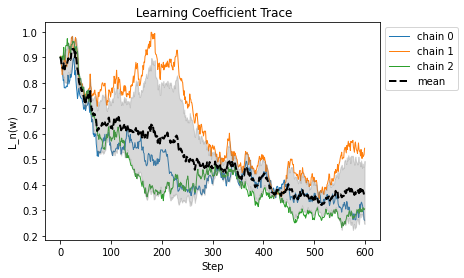

<Figure size 864x648 with 0 Axes>

In [6]:
learning_coeff_with_stats = estimate_learning_coeff_with_summary(
    value_network, 
    loader = dataloader, 
    criterion = torch.nn.MSELoss(),
    sampling_method=SGLD, 
    optimizer_kwargs=dict(lr=1e-6, elasticity=1., num_samples=datapoints),
    num_chains=3, 
    num_draws=600, 
    num_burnin_steps=0, 
    num_steps_bw_draws=1, 
    device=device
)


trace = learning_coeff_with_stats.pop("loss/trace")

print("Lambda hat estimates:")
print(yaml.dump(learning_coeff_with_stats))
plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
plt.show()
